In [46]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [47]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [48]:
NUM_CLASSES = 26

# Dataset reading

In [49]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [50]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [53]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 42)                168       
 Normalization)                                                  
                                                                 
 dense_9 (Dense)             (None, 64)                2752      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 26)                858       
                                                                 
Total params: 5858 (22.88 KB)
Trainable params: 5774 (22.55 KB)
Non-trainable params: 84 (336.00 Byte)
_________________

In [54]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [55]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [56]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
189/209 [==========================>...] - ETA: 0s - loss: 3.5710 - accuracy: 0.1697
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
209/209 [==============================] - 1s 2ms/step - loss: 3.5175 - accuracy: 0.1795 - val_loss: 2.9506 - val_accuracy: 0.2919
Epoch 2/1000
206/209 [============================>.] - ETA: 0s - loss: 2.6781 - accuracy: 0.3131
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
209/209 [==============================] - 0s 1ms/step - loss: 2.6775 - accuracy: 0.3129 - val_loss: 2.2875 - val_accuracy: 0.4228
Epoch 3/1000
200/209 [===========================>..] - ETA: 0s - loss: 2.3190 - accuracy: 0.3894
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
209/209 [==============================] - 0s 1ms/step - loss: 2.3144 - accuracy: 0.3908 - val_loss: 1.9718 - val_accuracy: 0.5158
Epoch 4/1000
209/209 [==============================] - ETA: 0s - loss: 2.1273 - a

In [57]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

70/70 [==============================] - 0s 804us/step - loss: 0.6870 - accuracy: 0.8496


In [58]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [59]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 37ms/step
[6.11906580e-05 2.17016810e-03 2.01734193e-02 9.98682459e-04
 2.94585945e-03 9.42229688e-01 4.28668223e-04 2.63177877e-04
 1.07311425e-05 8.58939311e-04 8.66182987e-03 1.84793360e-04
 1.26133737e-05 7.75652952e-05 8.70044343e-03 1.27482205e-03
 4.85421013e-04 3.62197966e-06 1.39939439e-04 4.46149534e-05
 3.76975804e-05 1.84456131e-03 5.72335208e-03 2.77008354e-07
 2.61964323e-03 4.81930801e-05]
5


# Confusion matrix

278/278 [==============================] - 0s 695us/step


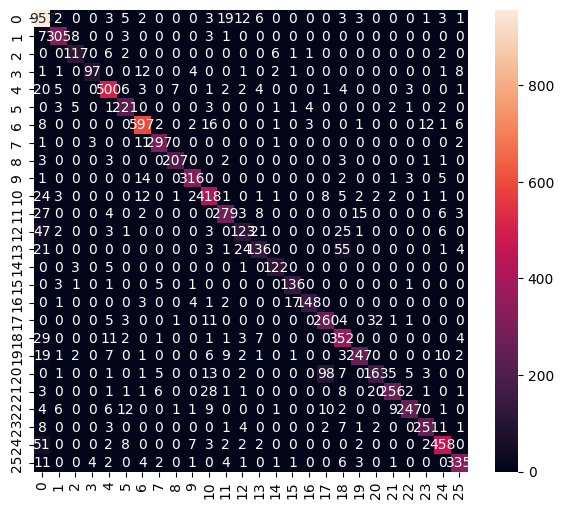

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1020
           1       0.92      0.93      0.92       327
           2       0.86      0.87      0.86       135
           3       0.93      0.76      0.84       128
           4       0.89      0.89      0.89       559
           5       0.84      0.91      0.87       244
           6       0.90      0.92      0.91       649
           7       0.93      0.94      0.94       315
           8       0.95      0.94      0.95       220
           9       0.93      0.92      0.93       342
          10       0.80      0.86      0.83       484
          11       0.86      0.80      0.83       347
          12       0.68      0.53      0.60       232
          13       0.73      0.56      0.63       245
          14       0.90      0.93      0.91       131
          15       0.86      0.92      0.89       148
          16       0.95      0.84      0.89       176
     

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [61]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [62]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpmvr6xoar\assets


INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpmvr6xoar\assets


11112

# Inference test

In [63]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [64]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [65]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [66]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4.09 ms


In [67]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.8479876e-05 2.2298361e-03 2.0193260e-02 8.9820713e-04 2.8051583e-03
 9.4505632e-01 3.4629798e-04 2.2068895e-04 9.5849109e-06 6.9662853e-04
 7.5589642e-03 1.7051116e-04 1.2795020e-05 7.4251497e-05 8.4792851e-03
 1.0768611e-03 3.5972960e-04 3.3751255e-06 1.3397963e-04 4.2043699e-05
 3.4723795e-05 1.6407273e-03 5.5591529e-03 2.7242726e-07 2.2963139e-03
 4.2531345e-05]
5
